# Determining $P$ Quality: Local Two-level Cycle and Mock Cycle
For constant $k$ (repetitive equations):
* Compare local two-level cycle and (local) mock cycle convergence rates to determine if $P$ is good or caliber needs to be increased.
* First approximation to $P = R^T$ where $R$ = SVD coarsening.

We compare $kh = 0$ with GS, 2/1 coarsening and $kh = 0.5$ with Kaczmarz, 4/2, 6/2 and 6/3 coarsening cases.

In [659]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [660]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 384 # 192 #96

kh = 0.5
num_sweeps = 80
aggregate_size = 4
num_components = 2

# Repetitive framework.
repetitive = True
# Number of test vectors.
num_examples = 3

nu_values = np.arange(1, 7)

## Coarsening $R$ and LMC Rate

In [661]:
def mock_conv_factor(kh, n, aggregate_size, num_components, num_sweeps: int = 5):
    # 'num_sweeps': number of relaxation sweeps to relax the TVs and to use in coarsening optimization
    # (determined by relaxation shrinkage).

    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, n)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    # For A*x=b cycle tests.
    b = np.random.random((a.shape[0], ))

    # Create relaxed vectors.
    x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
    b = np.zeros_like(x)
    x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)

    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    r = hrc.Coarsener(r)
    print("kh", kh, "a", aggregate_size, "nc", num_components, "#TV sweeps",
          num_sweeps, "#windows", x_aggregate_t.shape[0], "r", r.asarray(), "s", s)

    # Calculate mock cycle convergence rate.
    m_values = np.arange(2, 11, dtype=int)
    mock_conv = pd.DataFrame(np.array([
        mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
        for m in m_values]),
            index=m_values, columns=nu_values)

    return r, mock_conv

def mock_conv_factor_for_domain_size(kh, r, aggregate_size, m, nu_values):
    """Returns thre mock cycle conv factor for a domain of size m instead of n."""
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    # Use default Kacmzarz for kh != 0.
    level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    r_csr = r.tile(m // aggregate_size)
    return np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, r_csr, nu) for nu in nu_values])

In [662]:
# cases = [
#     (0, 2, 1, 5),      # Laplace
#     (0.5, 4, 2, 5),    # kh=0.5, 4/2
#     (0.5, 6, 3, 5),    # kh=0.5, 6/3
#     (0.5, 6, 2, 5),    # kh=0.5, 6/2 (Karsten found it to be good)
#     (0.5, 6, 2, 200),    # kh=0.5, 6/2 (Karsten found it to be good)
# ]
# case_conv = [mock_conv_factor(*case) for case in cases]

In [663]:
r, mock_conv = mock_conv_factor(kh, n, aggregate_size, num_components, num_sweeps=num_sweeps)
mock_conv[:5]

kh 0.5 a 4 nc 2 #TV sweeps 80 #windows 15 r [[ 0.495  0.578  0.531  0.373]
 [-0.638 -0.177  0.305  0.685]] s [0.072 0.037 0.002 0.   ]


,1,2,3,4,5,6
2,0.36,0.24,0.11,0.10,0.06,0.06
3,0.44,0.26,0.13,0.11,0.09,0.07
4,0.48,0.25,0.14,0.14,0.10,0.07
5,0.50,0.26,0.13,0.12,0.11,0.07
6,0.45,0.26,0.14,0.13,0.11,0.07


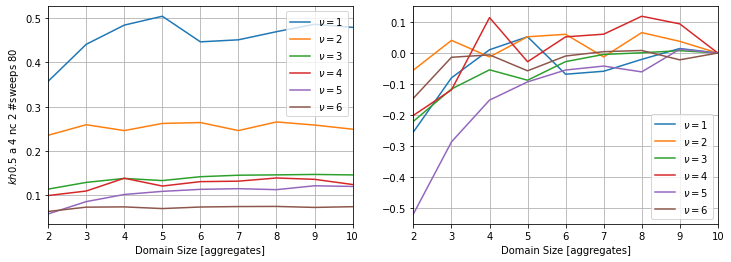

In [664]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

a, nc, conv = aggregate_size, num_components, mock_conv
# Mock cycle convergence vs. domain size [aggregates] and nu=1,...,6.
#print("kh {} a {} nc {} num_sweeps {}".format(kh, a, nc, num_sweeps))
#display(conv[:10])

ax_row = axs[row] if axs.ndim > 1 else axs
error = (conv - conv.iloc[-1]) / conv.iloc[-1]
nu_values = conv.columns
m_values = conv.index

ax = ax_row[0]
for nu in nu_values:
    ax.plot(m_values, conv[nu], label="$\\nu = {}$".format(nu))
ax.grid(True);
ax.set_xlim([2, 10]);
if row == len(cases) - 1:
    ax.set_xlabel("Domain Size [aggregates]")
ax.set_ylabel("$kh {}$ a {} nc {} #sweeps {}".format(kh, a, nc, num_sweeps))
if row == 0:
    ax.set_title("Mock Cycle Conv Factor");
ax.legend();

ax = ax_row[1]
for nu in nu_values:
    ax.plot(m_values, error[nu], label="$\\nu = {}$".format(nu))
ax.grid(True);
ax.set_xlim([2, 10]);
if row == len(cases) - 1:
    ax.set_xlabel("Domain Size [aggregates]")
if row == 0:
    ax.set_title("Relative Deviation from Asymptotic Value");
ax.legend();

$3-4$ aggregates are enough to show the mock cycle rate on the full domain.

## Two-level Cycle Rate with $P = R^T$

In [665]:
p = r.tile(1).transpose()
print(p.todense())
# caliber = 1
# p = hm.setup.auto_setup.create_interpolation(
#     x_level, level.a, r, interpolation_method, aggregate_size=aggregate_size, nc=nc, max_caliber=max_caliber,
#     neighborhood=neighborhood, repetitive=repetitive, target_error=target_error)
# for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
#     error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
#     error_a = norm(level.a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
#     _LOGGER.info(
#         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
#             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))


[[ 0.495 -0.638]
 [ 0.578 -0.177]
 [ 0.531  0.305]
 [ 0.373  0.685]]


In [666]:
def create_two_level_hiearchy(kh, m, r, p):
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    r_csr = r.tile(m // aggregate_size)
    p_csr = hm.linalg.tile_array(p, m // aggregate_size)
    level0 = hm.setup.hierarchy.create_finest_level(a) #, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    level1 = hm.setup.hierarchy.create_coarse_level(level0.a, level0.b, r_csr, p_csr)
    multilevel = hm.hierarchy.multilevel.Multilevel.create(level0)
    multilevel.add(level1)
    return multilevel

def two_level_conv_factor(multilevel, nu, print_frequency: int = None):
    level = multilevel.finest_level
    n = level.size
    # Test two-level cycle convergence for A*x=b with random b.
    b = np.random.random((n, ))
    two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
    residual = lambda x: b - multilevel[0].operator(x)
    return hm.solve.run.run_iterative_method(
        residual, two_level_cycle, np.random.random((n, )), 15, print_frequency=print_frequency)

In [667]:
# display(pd.DataFrame(multilevel[0].a.todense()[:10,:10]))
# display(pd.DataFrame(multilevel[1].r[:10,:10].todense()))
# display(pd.DataFrame(multilevel[1].p[:10,:10].todense()))
# display(pd.DataFrame(multilevel[1].a[:10,:10].todense()))

### Solving $Ax = b$ - Convergence History

INFO         0 |r| 7.212e+00 RER 1.27853
INFO         1 |r| 4.018e+00 (0.55717) RER 0.17429 (0.13632) 23.055
INFO         2 |r| 1.293e+00 (0.32166) RER 0.05977 (0.34292) 21.625
INFO         3 |r| 4.060e-01 (0.31409) RER 0.01894 (0.31686) 21.437
INFO         4 |r| 9.542e-02 (0.23504) RER 0.00444 (0.23440) 21.496
INFO         5 |r| 3.404e-02 (0.35680) RER 0.00158 (0.35625) 21.529
INFO         6 |r| 1.067e-02 (0.31348) RER 0.00050 (0.31339) 21.535
INFO         7 |r| 3.011e-03 (0.28209) RER 0.00014 (0.28210) 21.534
INFO         8 |r| 9.001e-04 (0.29899) RER 0.00004 (0.29899) 21.533
INFO         9 |r| 2.463e-04 (0.27368) RER 0.00001 (0.27368) 21.533
INFO        10 |r| 7.029e-05 (0.28532) RER 0.00000 (0.28532) 21.533
INFO        11 |r| 2.270e-05 (0.32294) RER 0.00000 (0.32294) 21.533
INFO        12 |r| 6.610e-06 (0.29119) RER 0.00000 (0.29119) 21.533
INFO        13 |r| 1.982e-06 (0.29985) RER 0.00000 (0.29985) 21.533
INFO        14 |r| 6.132e-07 (0.30938) RER 0.00000 (0.30938) 21.533
INFO   

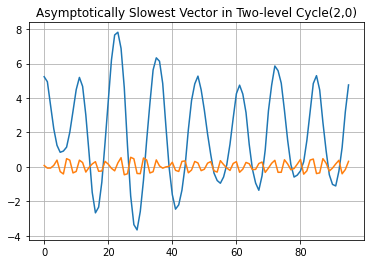

In [668]:
nu = 2
multilevel = create_two_level_hiearchy(kh, m, r, p)
y, _ = two_level_conv_factor(multilevel, nu, print_frequency=1)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(x);
plt.plot(e);
plt.grid(True);

### Level Operator Spectra

In [669]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.018 -0.018  0.044  0.044 -0.087 -0.087  0.098  0.098  0.144  0.144 -0.163 -0.163]
1 lam [-0.02  -0.02   0.043  0.043  0.094  0.094 -0.095 -0.095  0.135  0.135  0.167  0.167]


### Local Two-level Cycle Rate

In [670]:
# Calculate two-level cycle convergence rate vs. domain size.
m_values = np.arange(2, 11, dtype=int)
two_level_conv = pd.DataFrame(np.array([
    [two_level_conv_factor(create_two_level_hiearchy(kh, m * aggregate_size, r, p), nu)[1]
     for nu in nu_values]
    for m in m_values]),
        index=m_values, columns=nu_values)
two_level_conv

,1,2,3,4,5,6
2,0.50,0.33,0.41,0.38,0.37,0.36
3,0.48,0.38,0.35,0.33,0.28,0.25
4,0.48,0.31,0.41,0.39,0.36,0.35
5,0.48,0.30,0.39,0.34,0.32,0.29
6,0.44,0.33,0.40,0.34,0.34,0.32
7,0.44,0.31,0.39,0.36,0.33,0.32
8,0.46,0.30,0.41,0.38,0.32,0.34
9,0.44,0.28,0.40,0.34,0.33,0.33
10,0.45,0.29,0.38,0.38,0.31,0.34


Again, looks like $3-4$ aggregates are sufficient to get a constant two-level rate, provided that $P$ is good enough (i.e. (a) TVs are sufficiently smooth -- in this $n=96$ domain case, passed $80$ relaxation sweeps, and (b) the caliber is sufficiently large).